In [100]:
# Librerías para la importación de archivos
import pandas as pd
import numpy as np

# Liberías para graficos
import seaborn as sns
import matplotlib.pyplot  as plt

# Liberías para el tratamiento de los datos
import feature_engine
from feature_engine.imputation import AddMissingIndicator, CategoricalImputer, MeanMedianImputer, ArbitraryNumberImputer
from feature_engine.encoding import MeanEncoder, OrdinalEncoder, OneHotEncoder
from feature_engine.outliers import Winsorizer, ArbitraryOutlierCapper, OutlierTrimmer
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, SmartCorrelatedSelection
import category_encoders as ce
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from funpymodeling.exploratory import freq_tbl
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from category_encoders import TargetEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Selecciona features por su nombre. Servirá para aplicar pipelines a distintos datasets
    """
    def __init__(self, columns):
        """columns = lista de column names"""
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.columns]

In [104]:
# Loading data
df = pd.read_csv('bank-additional-full.csv', delimiter=';')

In [52]:
# Printing first 5 rows
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [53]:
# Checking shape of the dataset
df.shape

(41188, 21)

In [54]:
# Checking nulls per columns
print('Nulls values per columns')
df.isnull().sum()

Nulls values per columns


age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [55]:
# Checking for categorical columns
for col in df.columns:
    print()
    if df[col].dtype == 'object':
        print(f'Name of Column is: {col} and unique values are: {df[col].unique()}')



Name of Column is: job and unique values are: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']

Name of Column is: marital and unique values are: ['married' 'single' 'divorced' 'unknown']

Name of Column is: education and unique values are: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']

Name of Column is: default and unique values are: ['no' 'unknown' 'yes']

Name of Column is: housing and unique values are: ['no' 'yes' 'unknown']

Name of Column is: loan and unique values are: ['no' 'yes' 'unknown']

Name of Column is: contact and unique values are: ['telephone' 'cellular']

Name of Column is: month and unique values are: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']

Name of Column is: day_of_week and unique values are: ['mon' 'tue' 'wed' 'thu' 'fri']





Name of Column is: poutcome and unique valu

Although missing values ​​are not shown, in the categorical variables 'work', 'marital', 'education', 'default', 'housing', 'loan' are denominated with labels 'unknown' so I will replace them with null values after doing the descriptive analysis with graphics.

In [7]:
# Chequeo el tipo de datos
dataset.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [8]:
# Checking the mean, standard deviation and percentiles for numerical variables
per = [0.01,0.02,0.03, 0.05, 0.1,0.25,0.5,0.75,0.9,0.95,0.98,0.99]
dataset.describe(percentiles = per)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
1%,23.00000,11.000000,1.000000,3.000000,0.000000,-3.400000,92.201000,-49.500000,0.658480,4963.600000
2%,24.00000,17.000000,1.000000,6.000000,0.000000,-3.400000,92.379000,-47.100000,0.714000,4991.600000
3%,25.00000,23.000000,1.000000,9.000000,0.000000,-3.000000,92.431000,-47.100000,0.720000,4991.600000
5%,26.00000,36.000000,1.000000,999.000000,0.000000,-2.900000,92.713000,-47.100000,0.797000,5017.500000
10%,28.00000,59.000000,1.000000,999.000000,0.000000,-1.800000,92.893000,-46.200000,1.046000,5076.200000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000


### Plots for categorical variables

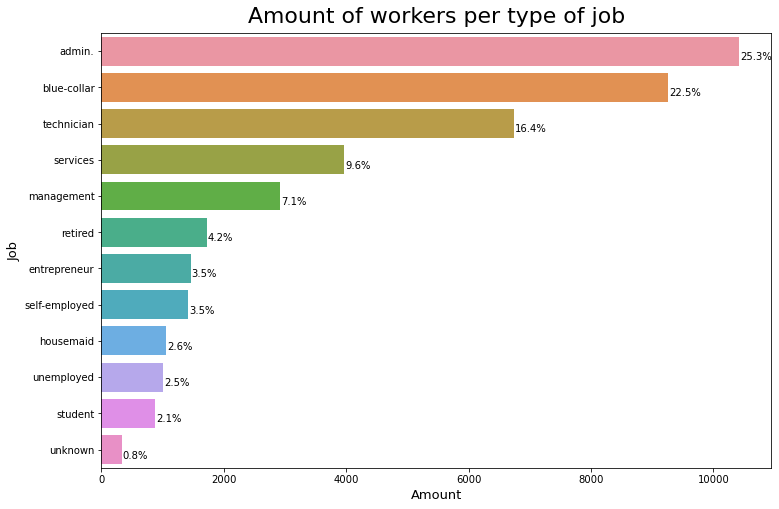

In [77]:
plt.figure(figsize = (12,8))
plt.title('Amount of workers per type of job', size = 22, weight=400, pad=10, loc = 'center')
ax = sns.countplot(data = df, y = "job", order = dataset['job'].value_counts().index, ) 
plt.xlabel('Amount', size=13)
plt.ylabel('Job', size=13)

total = len(df['job'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width()+20
        y = p.get_y() + p.get_height()/1.25
        ax.annotate(percentage, (x, y))

plt.show()




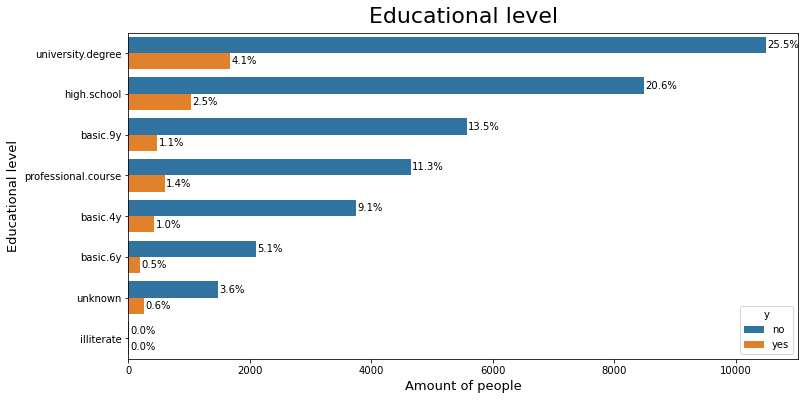

In [65]:
plt.figure(figsize = (12,6))
plt.title('Educational level', size = 22, weight=400, pad=10, loc = 'center')
ax = sns.countplot(data = df, y = "education", order = df['education'].value_counts().index, hue= df['y']) 
plt.xlabel('Amount of people', size=13)
plt.ylabel('Educational level', size=13)

total = len(df['education'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 20
        y = p.get_y() + p.get_height()/1.5
        ax.annotate(percentage, (x, y))

plt.show()



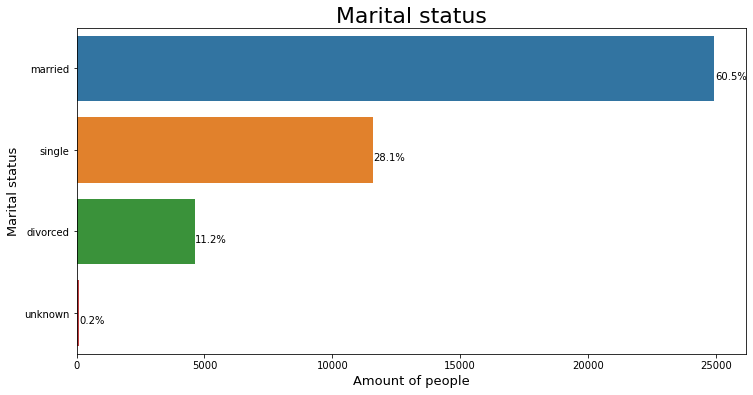

In [66]:
plt.figure(figsize = (12,6))
plt.title('Marital status', size = 22, weight=400, pad=5, loc = 'center')
ax = sns.countplot(data = df, y = "marital", order = df['marital'].value_counts().index) 
plt.ylabel('Marital status', size=13)
plt.xlabel('Amount of people', size=13)

total = len(df['default'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 20
        y = p.get_y() + p.get_height()/1.5
        ax.annotate(percentage, (x, y))
plt.show()

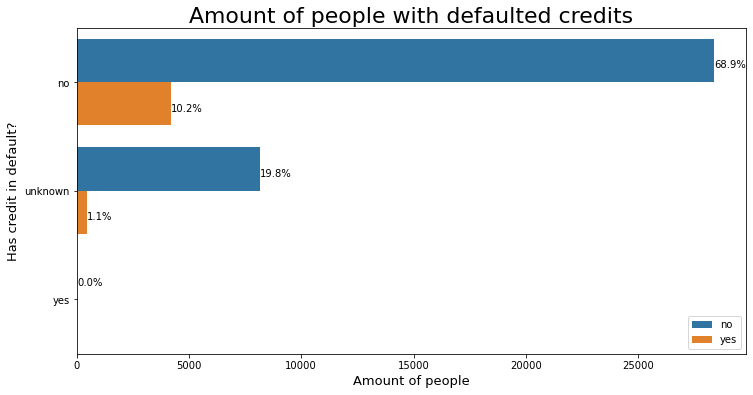

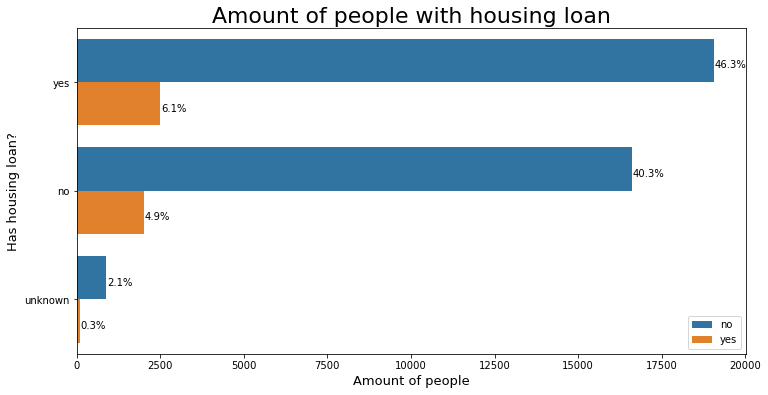

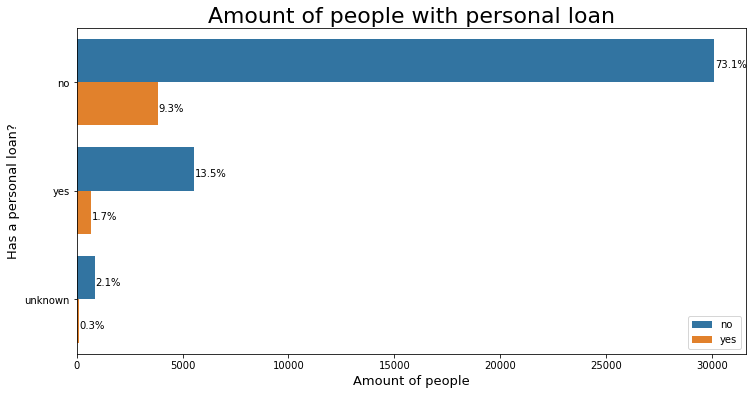

In [67]:
plt.figure(figsize = (12,6))
plt.title('Amount of people with defaulted credits', size = 22, weight=400, pad=5, loc = 'center')
ax = sns.countplot(data = df, y = "default", order = df['default'].value_counts().index, hue= df['y']) 
plt.ylabel('Has credit in default?', size=13)
plt.xlabel('Amount of people', size=13)
plt.legend(loc ="lower right")
total = len(df['default'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 20
        y = p.get_y() + p.get_height()/1.5
        ax.annotate(percentage, (x, y))
plt.show()


plt.figure(figsize = (12,6))
plt.title('Amount of people with housing loan', size = 22, weight=400, pad=5, loc = 'center')
ax = sns.countplot(data = df, y = "housing", order = df['housing'].value_counts().index, hue= df['y']) 
plt.xlabel('Amount of people', size=13)
plt.ylabel('Has housing loan?', size=13)
plt.legend(loc ="lower right")
total = len(df['housing'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 20
        y = p.get_y() + p.get_height()/1.5
        ax.annotate(percentage, (x, y))
plt.show()


plt.figure(figsize = (12,6))
plt.title('Amount of people with personal loan', size = 22, weight=400, pad=5, loc = 'center')
ax = sns.countplot(data = df, y = "loan", order = df['loan'].value_counts().index, hue= df['y']) 
plt.xlabel('Amount of people', size=13)
plt.ylabel('Has a personal loan?', size=13)
plt.legend(loc ="lower right")
total = len(df['loan'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 20
        y = p.get_y() + p.get_height()/1.5
        ax.annotate(percentage, (x, y))
plt.show()

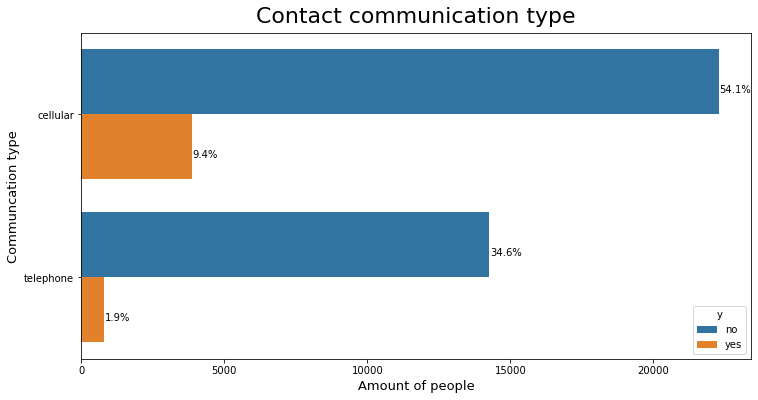

In [68]:
plt.figure(figsize = (12,6))
plt.title('Contact communication type', size = 22, weight=400, pad=10, loc = 'center')
ax = sns.countplot(data = df, y = "contact", order = df['contact'].value_counts().index, hue= df['y']) 
plt.xlabel('Amount of people', size=13)
plt.ylabel('Communcation type', size=13)

total = len(df['contact'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 20
        y = p.get_y() + p.get_height()/1.5
        ax.annotate(percentage, (x, y))
plt.show()

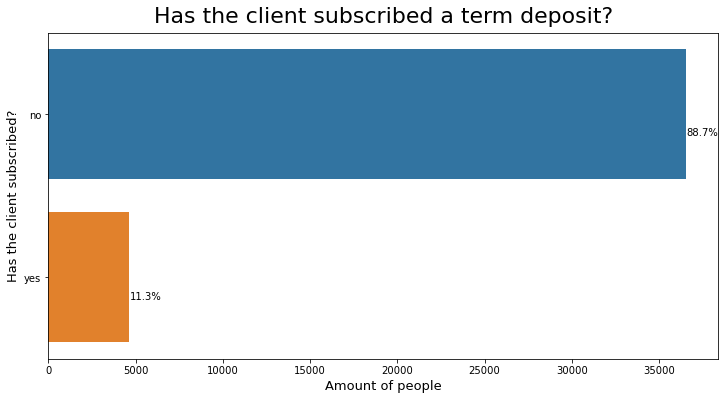

In [69]:
plt.figure(figsize = (12,6))
plt.title('Has the client subscribed a term deposit?', size = 22, weight=400, pad=10, loc = 'center')
ax = sns.countplot(data = df, y = "y", order = df['y'].value_counts().index) 
plt.xlabel('Amount of people', size=13)
plt.ylabel('Has the client subscribed?', size=13)

total = len(df['y'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 20
        y = p.get_y() + p.get_height()/1.5
        ax.annotate(percentage, (x, y))
plt.show()

We can observe that the target variable is imbalanced.

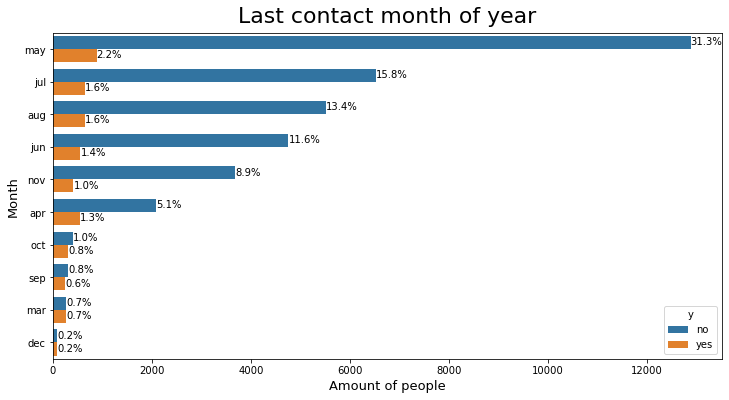

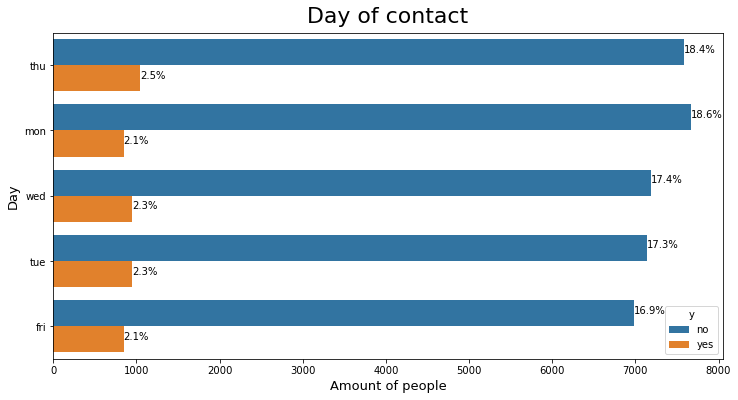

In [71]:
plt.figure(figsize = (12,6))
plt.title('Last contact month of year', size = 22, weight=400, pad=10, loc = 'center')
ax = sns.countplot(data = df, y = "month", order = df['month'].value_counts().index, hue= df['y']) 
plt.xlabel('Amount of people', size=13)
plt.ylabel('Month', size=13)

total = len(df['job'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/1.5
        ax.annotate(percentage, (x, y))

plt.show()

plt.figure(figsize = (12,6))
plt.title('Day of contact', size = 22, weight=400, pad=10, loc = 'center')
ax = sns.countplot(data = df, y = "day_of_week", order = df['day_of_week'].value_counts().index, hue= df['y']) 
plt.xlabel('Amount of people', size=13)
plt.ylabel('Day', size=13)

total = len(df['day_of_week'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

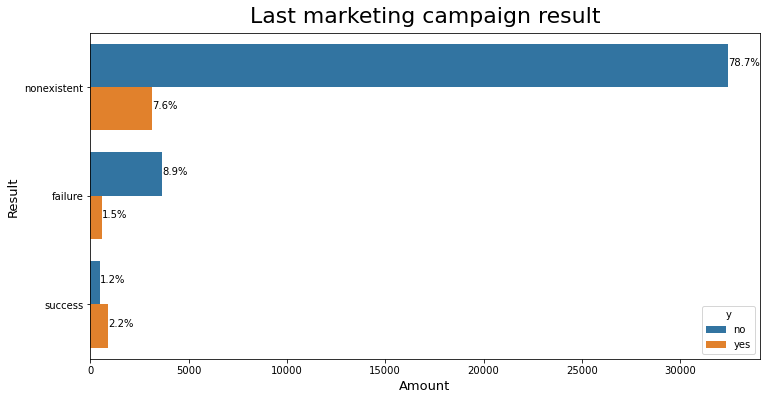

In [72]:
plt.figure(figsize = (12,6))
plt.title('Last marketing campaign result', size = 22, weight=400, pad=10, loc = 'center')
ax = sns.countplot(data = df, y = "poutcome", order = df['poutcome'].value_counts().index, hue= df['y']) 
plt.xlabel('Amount', size=13)
plt.ylabel('Result', size=13)

total = len(df['poutcome'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

1. Job: The highest number (about 25% of workers) of applications comes from the administrator job type.
2. Default: this variable has no impact on the customer who subscribes to the term deposit. As we can see with no as input, the customer took the term deposit and the customer who has credit does not accept the term deposit. So we will remove this function.
3. Marital status: About 60% of the clients contacted were married.
4. Education: About 25% of the clients contacted had a university degree, and 20% had a secondary degree. These two groups have a higher success rate than the rest (in terms of accepting the deposit).
5. Housing: The mortgage loan does not have much effect on the number of fixed terms purchased.
6. Loan: About 84% of the people contacted without having a personal loan.
7. Contact: Around 64% of the people contacted are by cell phone.
8. Month: About 33% of people were contacted in May. In January and February we have no data or no one was contacted.
9. day_of_week: There are no differences in the number of clients contacted on the different days of the week.
10. poutcome: If a customer took the fixed term last time, there is a greater chance that he will buy again.

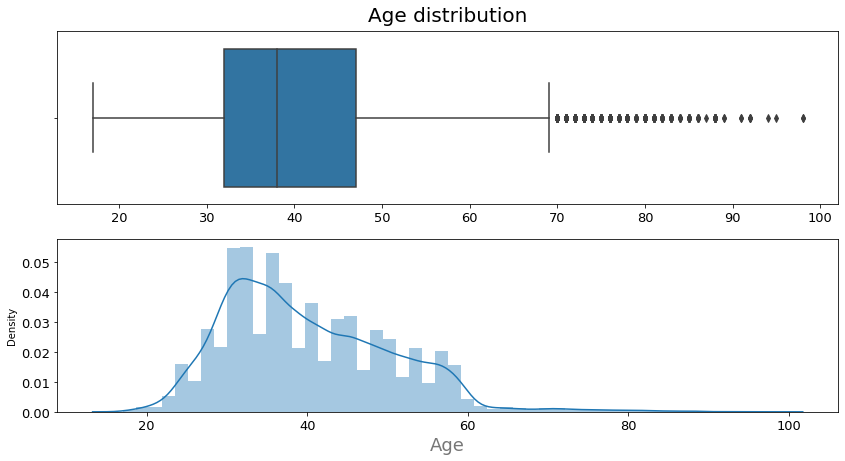

In [73]:
plt.figure(figsize = (14,7))
plt.subplot(2,1,1)
sns.boxplot(dataset['age'])
plt.xticks(fontsize=13 )
plt.xlabel("")
plt.title('Age distribution', weight=20, size = 20, pad = 10)
#ax.tick_params(axis="x", labelsize=15)
plt.subplot(2,1,2)
sns.distplot(df['age'], kde = True)
plt.xlabel('Age', size = 18, color='#777777')
plt.xticks(fontsize=13 )
plt.yticks(fontsize=13 )


plt.show()

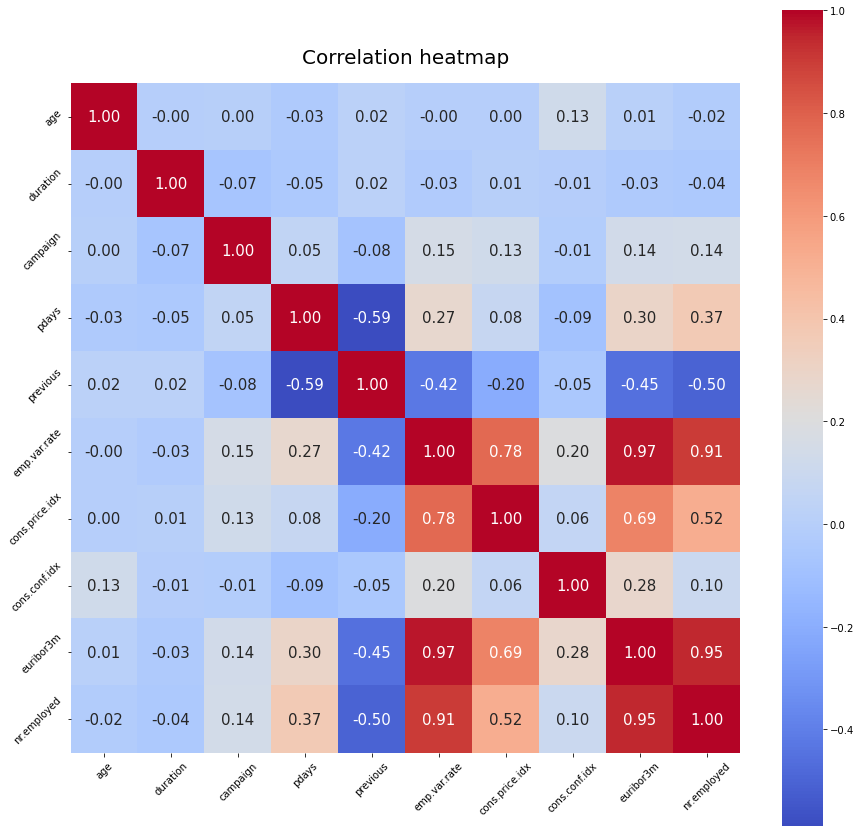

In [75]:
corr = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           cmap= 'coolwarm')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.title("Correlation heatmap", size=20, pad=20)
plt.show()

We can see some correlation between emp. var rate and nr.employed. Also, between emp. var rate and euribor3m.



In [105]:
# Modifying the columns: we assign weight on the basis of importance
df['job'] = df['job'].apply(lambda x: -1 if x=='unknown' or x=='unemployed' else (15 if x=='entrepreneur' else (8 if x == 'blue-collar' else ( 6 if x=='technician' or x=='services' or  x=='admin.' or x=='management' else (4 if x== 'self-employed' or x=='student' else (2 if x=='housemaid' or x=='retired' else None) )))))
df['housing'] = df['housing'].apply(lambda x: 0 if x=='no' else (1 if x=='yes' else -1))
df['loan'] = df['loan'].apply(lambda x: 0 if x=='no' else (1 if x=='yes' else -1))
df['y'] = df['y'].apply(lambda x: 0 if x=='no' else (1 if x=='yes' else -1))
df['default'] = df['default'].apply(lambda x: 0 if x=='no' else (1 if x=='yes' else -1))
df['poutcome'] = df['poutcome'].apply(lambda x: 0 if x=='failure' else (2 if x=='failure' else -1))
df['pdays'] = df['pdays'].apply(lambda x: 0 if x==999 else(20 if x<=10 else(6 if x<=20 else 3)))



In [106]:
df  = pd.get_dummies(df, drop_first = True)

In [107]:
df.head() 

,age,job,default,housing,loan,duration,campaign,pdays,previous,poutcome,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,56,2,0,0,0,261,1,0,0,-1,...,0,0,1,0,0,0,1,0,0,0
1,57,6,-1,0,0,149,1,0,0,-1,...,0,0,1,0,0,0,1,0,0,0
2,37,6,0,1,0,226,1,0,0,-1,...,0,0,1,0,0,0,1,0,0,0
3,40,6,0,0,0,151,1,0,0,-1,...,0,0,1,0,0,0,1,0,0,0
4,56,6,0,0,1,307,1,0,0,-1,...,0,0,1,0,0,0,1,0,0,0


In [108]:
# Train Test Split
x = df.drop("y", axis=1)
y = df['y']
x.sample()

x_train,x_test,y_train,y_test = train_test_split(x,y, random_state=42)

In [109]:
# Balancing the data using SMOTE (oversampling)
smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(x_train, y_train)

print('Original dataset shape', len(x_train))
print('Resampled dataset shape', len(x_smote))

Original dataset shape 30891
Resampled dataset shape 54808


In [110]:
# For scaling the data
s = StandardScaler()

In [112]:
# Functions for classifiers and hyperparameter tuning

def classifier(clf, x_train,x_test,y_train,y_test):
    y_test_pred = clf.predict(x_test)
    y_train_pred = clf.predict(x_train)

    accuracy_test = accuracy_score(y_test,y_test_pred)
    accuracy_train =  accuracy_score(y_train,y_train_pred)
    
    roc_test = roc_auc_score(y_test, y_test_pred, multi_class='ovr')
    roc_train = roc_auc_score(y_train, y_train_pred, multi_class='ovr')
    
    print('Train accuracy is:',accuracy_train )
    print('Test accuracy is:',accuracy_test )
    print()
    print('Train ROC is:', roc_train)
    print('Test ROC is:',roc_test )
    
    # Fscore, precision and recall on test data
    f1 = f1_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred) 
    print()
    print("F score is:",f1 )
    print("Precision is:",precision)
    print("Recall is:", recall)
  
def random_search(clf,params, x_train,x_test,y_train,y_test):
    
    random_search = RandomizedSearchCV(estimator= clf, param_distributions=params, scoring='roc_auc', cv=5)
    random_search.fit(x_train, y_train)
    optimal_model = random_search.best_estimator_

    print("Best parameters are: ", random_search.best_params_)
    print()
    print("Best estimator is: ", random_search.best_estimator_)
    print()
    print('Scores and accuracies are:')
    print()
    classifier(optimal_model, x_train,x_test,y_train,y_test)

In [113]:
from sklearn.neighbors import KNeighborsClassifier
# Model: KNN
knn = KNeighborsClassifier(n_neighbors=22)

# Fitting the model
knn.fit(s.fit_transform(x_train), y_train)

# Making the prediction
classifier(knn, s.fit_transform(x_smote),s.transform(x_test), y_smote,y_test)


Train accuracy is: 0.5675448839585462
Test accuracy is: 0.893949694085656

Train ROC is: 0.5675448839585461
Test ROC is: 0.5582862690732608

F score is: 0.20984081041968158
Precision is: 0.6331877729257642
Recall is: 0.12575888985255854


In [115]:
# Looking for minimun error rate
error_rate = []
for i in range(1,25):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit( s.fit_transform(x_train), y_train)
    pred_i = knn.predict(s.transform(x_test))
    error_rate.append(np.mean(pred_i != y_test))


Minimum error:- 0.09993201903467029 at K = 17


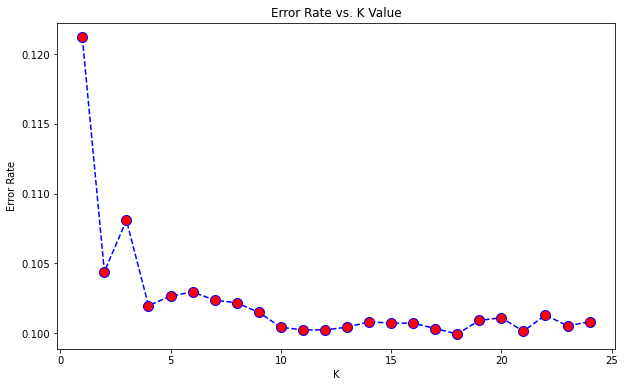

In [118]:
plt.figure(figsize=(10,6))
plt.plot(range(1,25),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

In [120]:
# Looking for maximum accuracy
acc = []
for i in range(1,25):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(s.fit_transform(x_train), y_train)
    yhat = neigh.predict(s.transform(x_test))
    acc.append(metrics.accuracy_score(y_test, yhat))

Maximum accuracy:- 0.9000679809653297 at K = 17


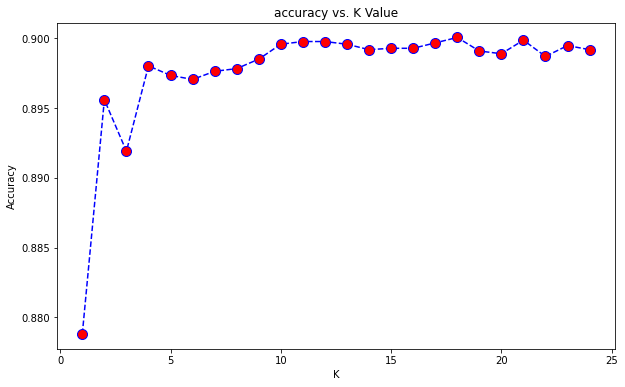

In [121]:
plt.figure(figsize=(10,6))
plt.plot(range(1,25),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

In [122]:
# Best parameters for KNN 
knn = KNeighborsClassifier(n_neighbors = 17)
knn.fit( s.fit_transform(x_smote), y_smote)

classifier(knn, s.fit_transform(x_smote),s.transform(x_test),y_smote,y_test)

Train accuracy is: 0.9240074441687345
Test accuracy is: 0.8753034864523648

Train ROC is: 0.9240074441687345
Test ROC is: 0.7099870321933955

F score is: 0.47160493827160493
Precision is: 0.4487079091620987
Recall is: 0.49696444058976585


In [131]:
from sklearn.tree import DecisionTreeClassifier

# Model: Decision Tree Classifier
tree_classifier = DecisionTreeClassifier(max_depth=10,criterion='gini') 

# Fitting the model
tree_classifier.fit(s.fit_transform(x_smote), y_smote)

# Making the predictions
classifier(tree_classifier, s.fit_transform(x_smote),s.transform(x_test),y_smote,y_test)

Train accuracy is: 0.9442964530725442
Test accuracy is: 0.872390016509663

Train ROC is: 0.9442964530725442
Test ROC is: 0.7989206046230345

F score is: 0.5527569775357386
Precision is: 0.4549019607843137
Recall is: 0.7042497831743278


In [132]:
# Best parameters for decision tree classifier 
param_grid = {'max_depth':np.arange(3,20),
              'min_samples_split': np.arange(3,20,1),
             'min_samples_leaf':np.arange(3,30),
              'min_samples_split' : np.arange(3,30),
              'criterion': ('gini', 'entropy')}



random_search(DecisionTreeClassifier(random_state=0),param_grid, s.fit_transform(x_smote),s.transform(x_test),y_smote,y_test)

Best parameters are:  {'min_samples_split': 9, 'min_samples_leaf': 28, 'max_depth': 10, 'criterion': 'entropy'}

Best estimator is:  DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=28,
                       min_samples_split=9, random_state=0)

Scores and accuracies are:

Train accuracy is: 0.9290796963946869
Test accuracy is: 0.8864717878993882

Train ROC is: 0.9290796963946869
Test ROC is: 0.8333772485941426

F score is: 0.6014319809069212
Precision is: 0.49550561797752807
Recall is: 0.7649609713790113


In [130]:
from sklearn.ensemble import RandomForestClassifier
# Model: Random Forest
rf = RandomForestClassifier(max_depth = 13)

# Fitting the model
rf.fit(s.fit_transform(x_smote), y_smote)

# Making the predictions
classifier(rf, s.fit_transform(x_smote),s.transform(x_test),y_smote,y_test)

Train accuracy is: 0.9704422712012845
Test accuracy is: 0.9023016412547344

Train ROC is: 0.9704422712012845
Test ROC is: 0.8210678389290671

F score is: 0.6215199398043643
Precision is: 0.5488372093023256
Recall is: 0.7163920208152645


In [134]:
# Best parameters for Random Forest Classifier
params = {'n_estimators' : np.arange(100,1000, 100),
              'max_depth' : np.arange(3,20,1),
              'min_samples_split' : np.arange(2,15,1),
              'min_samples_leaf' : np.arange(3,20,1),
         'max_features': ('sqrt', 'log2'), 'criterion': ('gini', 'entropy')}

random_search(RandomForestClassifier(random_state=0),params, s.fit_transform(x_smote),s.transform(x_test),y_smote,y_test)

Best parameters are:  {'n_estimators': 900, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 19, 'criterion': 'gini'}

Best estimator is:  RandomForestClassifier(max_depth=19, max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=5, n_estimators=900, random_state=0)

Scores and accuracies are:

Train accuracy is: 0.9682710553203911
Test accuracy is: 0.9090026221229485

Train ROC is: 0.9682710553203911
Test ROC is: 0.8187772739378957

F score is: 0.6335549472037545
Precision is: 0.5769230769230769
Recall is: 0.7025151777970512


In [135]:
import xgboost as xgb
# Model: XGBoost
xgb_clf = xgb.XGBClassifier()

# Fitting the model
xgb_clf.fit(s.fit_transform(x_smote), y_smote)

# Making the predictions
classifier(xgb_clf, s.fit_transform(x_smote),s.transform(x_test),y_smote,y_test)

[20:27:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train accuracy is: 0.9745475113122172
Test accuracy is: 0.9097795474410022

Train ROC is: 0.9745475113122172
Test ROC is: 0.7748751497671638

F score is: 0.5987041036717062
Precision is: 0.5963855421686747
Recall is: 0.601040763226366


In [136]:
# Best parameters for XGBoost Classifier
params = {'max_depth' : [2,3,5,7],
               'learning_rate' : [0.01,0.1,0.2],
               'subsample' : np.arange(0.8, 1, 0.01),
               'colsample_bytree' : np.arange(0.7, 1, 0.01),
               'colsample_bylevel' : np.arange(0.5, 1, 0.1),
               'n_estimators' : [50,100,200,500,1000,1200]}

random_search(xgb.XGBClassifier(),params, s.fit_transform(x_smote),s.transform(x_test),y_smote,y_test)

[20:30:58] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:51] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

[20:37:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:37:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:37:46] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

[20:44:01] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:45:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:46:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

Optimized Decision Tree Classifier and optimized Random Forest seems to be the best models for this problem according Recall and ROC.
